# Fourier downsampleing of cut fields

This document a study of data-reduction by fourier series downsampling methods. The idea is that antenna radiation patterns often are based on Sinc functions, at least locally and close to the maximum radiation intensity. 

So for a radiation pattern $U(\theta,\phi)$ with a pattern theta cut $U_c(\theta) = U(\theta,\phi = c)$ where $c$ is an arbitrary constant

$$U_c(\theta) \approx B\left(\frac{\sin(a\theta)}{a\theta}\right)^2$$


The Fourier Transform of a 
$$$$


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


cwd = Path.cwd()
cut_folder = cwd / "Field Cut Data" / "cut_files"
log_folder = cwd / "Field Cut Data" / "log_files"
print(cwd)


C:\Users\Niels\Documents\GitHub\Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction\Prelimary Data Analysis


Signal Power 10.365856702671376
FFT Power 10.365856702671374
46
12


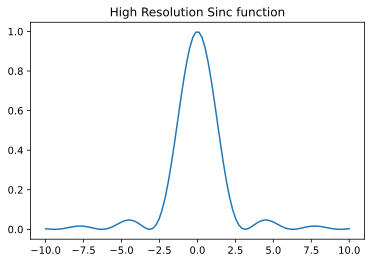

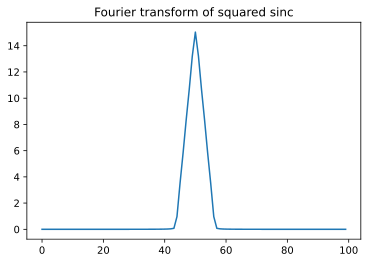

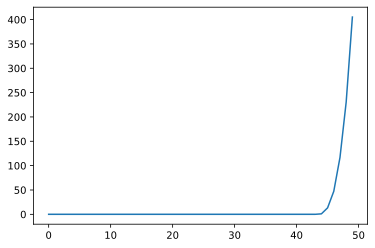

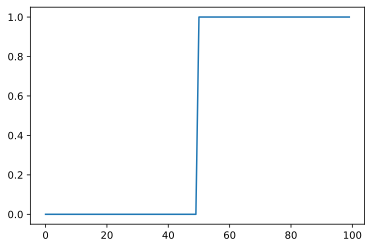

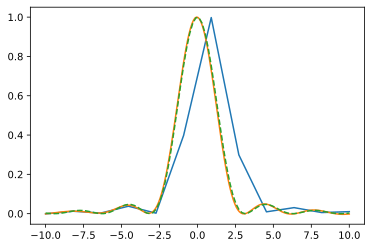

In [2]:
from scipy.fft import fft,ifft
from scipy.signal import resample

x = np.linspace(-10,10,100)
y = abs((np.sin(x)/(x))**2)
print('Signal Power', np.sum(abs(y)**2))

##Simple squared sinc wave
plt.figure()
plt.title('High Resolution Sinc function')
plt.plot(x,y)

y_fft = fft(y)
print('FFT Power',np.sum(abs(y_fft)**2)/len(y_fft))
plt.figure()
plt.title('Fourier transform of squared sinc')
plt.plot(np.roll(abs(y_fft),len(y_fft)//2))
shifted_fft = np.roll(abs(y_fft),len(y_fft)//2)
shifted_fft_power = shifted_fft**2;
integrated_fft_power = np.cumsum(shifted_fft)


plt.figure()
plt.plot(np.cumsum(shifted_fft_power[0:int(len(y_fft)//2)]))

plt.figure()
plt.plot(integrated_fft_power > np.trapz(shifted_fft)/2)
print(len(integrated_fft_power[integrated_fft_power < (np.trapz(shifted_fft)/2)*0.1]))


resampleNumber = len(y)-2*len(integrated_fft_power[integrated_fft_power < (np.trapz(shifted_fft)/2)*0.01])
print(resampleNumber)

y_downsample = resample(y,resampleNumber)
plt.figure()
x1 = np.linspace(-10,10,resampleNumber)
plt.plot(x1,y_downsample)
x2 = np.linspace(-10,10,200)
plt.plot(x2,resample(y_downsample,200))
plt.plot(x,y,linestyle = '--')

# Parsevals theorem based downsampler

So what if we used parsevals theorem (The idea that we can find the power of a signal in the fourier domain) to determine at which frequency a certain percentage of the power is properly respresented?

43
Power of original Signal 33.333205492295065
Power new signal 33.29990512304738
Difference 0.09990151150921404 %


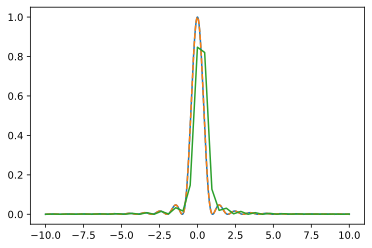

In [6]:
import scipy

x = np.linspace(-10,10,1001)
a = 1;
y = (np.sinc(a*x))**2

def parsevalDownsampler(y, powerLossFactor):
    
    l = len(y)
    y_fft = fft(y)
    shifted_fft = np.roll(abs(y_fft),l//2)
    y_power = y**2
    int_power = np.sum(y_power)
    integrated_fft_power = np.cumsum(shifted_fft)
    
    N = len(y)-2*len(integrated_fft_power[integrated_fft_power < (np.sum(shifted_fft)/2)*powerLossFactor])
    if N%2 == 0:
        N = N + 1
    
    
    down_sampled_signal=scipy.signal.resample(y,N)
    
    
    return N,down_sampled_signal



N,y_downsample = parsevalDownsampler(y,0.0001)
print(N)

plt.figure()
plt.plot(x,y)
x1 = np.linspace(-10,10,N)
plt.plot(x,resample(y_downsample,1001),linestyle = '--')
plt.plot(x1,y_downsample)

print('Power of original Signal',np.sum(y**2))
print('Power new signal',np.sum(resample(y_downsample,1000)**2))
print('Difference',100*(np.trapz(y**2)-np.trapz(resample(y_downsample,1000)**2))/np.sum(y**2),'%')

In [4]:
cwd = Path.cwd()
cut_folder = cwd / "Field Cut Data" / "cut_files"
log_folder = cwd / "Field Cut Data" / "log_files"
print(cwd)
file_to_open = cut_folder / "2.cut"
V_INI, V_INC, V_NUM, C, ICOMP, ICUT, NCOMP = np.genfromtxt(file_to_open, max_rows=1, skip_header=1)
print(V_INI, V_INC, V_NUM, C, ICOMP, ICUT, NCOMP)
data = np.genfromtxt(file_to_open, skip_header=2,dtype = np.float32).T
print(data.shape)
thetas = np.linspace(-45.0, 45.0, int(V_NUM))
copolar = np.sqrt(data[0]**2 + data[1]**2)
xpolar = np.sqrt(data[2]**2 + data[3]**2)
copolar_dB = 10*np.log10(copolar)
xpolar_dB = 10*np.log10(xpolar)

C:\Users\Niels\Documents\GitHub\Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction\Prelimary Data Analysis
-45.0 0.09 1001.0 0.0 3.0 1.0 2.0
(4, 1001)


Number of points 49


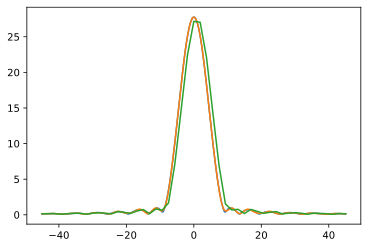

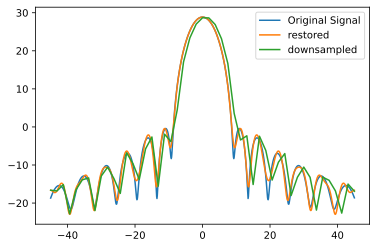

In [5]:
plt.figure()
plt.plot(thetas,copolar)

N,downsample = parsevalDownsampler(copolar,0.01)
print('Number of points',N)
plt.plot(np.linspace(-45,45,1001),resample(downsample,1001))
plt.plot(np.linspace(-45,45,N),downsample)

plt.figure()
plt.plot(thetas,20*np.log10(copolar),label = 'Original Signal')
plt.plot(np.linspace(-45,45,1001),20*np.log10(resample(downsample,1001)),label = 'restored')
plt.plot(np.linspace(-45,45,N),20*np.log10(downsample),label = 'downsampled')
plt.legend()
